This notebook compares different approximation strategies for the state-traching task with a differential drive robot with and without actuator model.

For our experiment, we compare the following MPCs. As ground truth model we consider the model integrated with step size 0.005. Consistently, we simulate at 200Hz and apply the MPCs with a frequency (zero order hold) corresponding to their initial step size.


0.) Baseline: Naive Long Horizon MPC, step size is 0.01 and we have an enormous horizon length of 1000. Thus, the MPC's planning horizon captures half of the entire 20s simulation. The MPC reaches a state very close to the goal state and achieves small costs. 

1.) Exact-model MPC with a larger initial step size of 0.02 and a horizon of 1000 (again overlooking half the simulaiton horizon). The MPC does not work at all, and the solver frequently fails. My understanding: The larger step size is too large and the dynamics of the MPC do not accurately capture the ground truth system anymore. 

2.) Larger integration step sizes and a corresponding lower frequency.

4.) Exact-model MPC with exponential increase of step size at an sensible rate. We choose 80 stages. The time horizon is still 20s to achieve a far lookahead distance.

5.) Model-switching: Same as 0), but model is switched roughly at the same switching time as 6)

6.) Our approach: Combining exponential increase of step size with model switching after stage 20. Neglecting the fast actuator dynamics, we not only reduce the dimension of the state but can switch to ERK for the second part of the horizon, which is much cheaper than using the implicit IRK.

7.) To show that implicite integration is neccessary: exactly as 0), but integrated with ERK. We get solver errors, es ERK cannot handle the stiff dynamics. 

In [1]:

from differential_drive.Differential_drive_MPC import DifferentialDriveMPC, DifferentialDriveMPCOptions
import gc
import shutil
import numpy as np
import matplotlib.pyplot as plt
from differential_drive.utils_diff_drive import simulate_closed_loop
from utils_shared import compute_exponential_step_sizes
from differential_drive.plotting_utils_diff_drive import plot_diff_drive_trajectory

In [2]:
# initialize sim solver for closed loop simulation, we also use the DifferentialDrive MPC class to instatiate the sim solver.
mpc_opts_sim = DifferentialDriveMPCOptions()
mpc_opts_sim.N = 1
dt_sim = 0.005
mpc_opts_sim.step_sizes = [dt_sim]*1
mpc_opts_sim.switch_stage = 2
mpc_sim = DifferentialDriveMPC(mpc_opts_sim)
sim_solver = mpc_sim.acados_sim_solver

# MPC config shared by all MPCs 
dt_inital_mpc = 0.01
control_step = int(dt_inital_mpc/dt_sim) # determines zero order hold of the MPC
X0 = np.array([-1.0, 1.0, 0.0, -np.pi/2, 0.0, 0.0, 0.0])
duration = 15.0 # was 15.0

# collect mean costs and solve times
mean_costs = []
mean_solve_times = []
mean_solve_time_per_iter = []

del mpc_sim
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

# for plotting
initial_state_plotting = np.vstack([X0[0], X0[1], X0[3]])
y_ref_plotting = np.zeros(3)
latexify=True
save=True


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

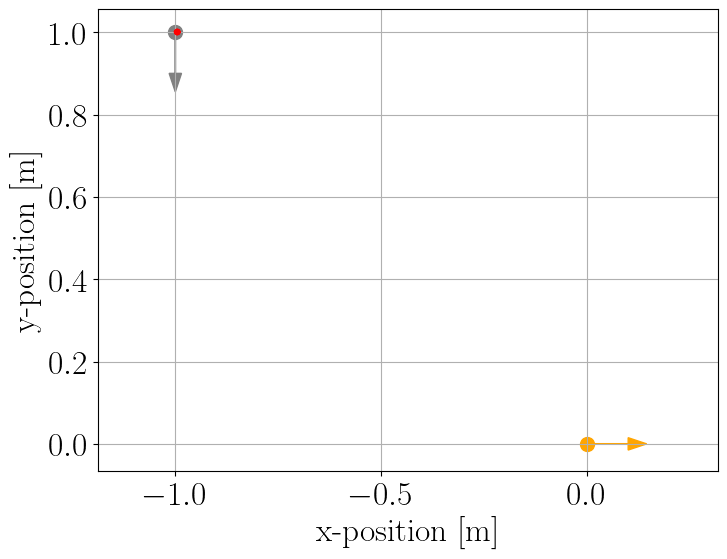

In [3]:
### -1) ERK usage (to show that IRK is necessary) ###
mpc_opts_ERK = DifferentialDriveMPCOptions()
N = 1000
mpc_opts_ERK.N = N
mpc_opts_ERK.step_sizes = [dt_inital_mpc]*N
mpc_opts_ERK.switch_stage = N+1
mpc_opts_ERK.integrator_type = "ERK"
mpc_ERK = DifferentialDriveMPC(mpc_opts_ERK)

x_traj_ERK, u_traj_ERK, stage_costs, solve_times, SQP_iters = simulate_closed_loop(X0, mpc_ERK, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(y_ref_plotting, mpc=mpc_ERK, closed_loop_traj=x_traj_ERK, latexify=latexify, number=None, legend=False, save=False, initial_state=initial_state_plotting)
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]

del mpc_ERK
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

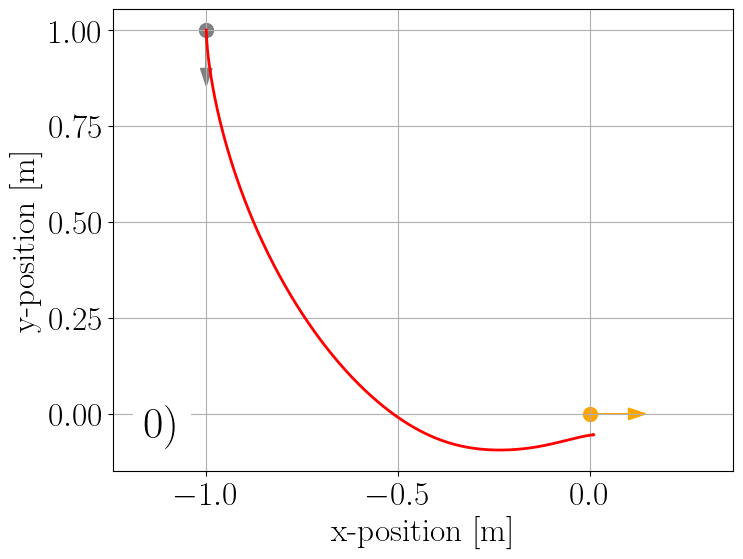

In [4]:
### 0) Baseline ###
mpc_opts_baseline = DifferentialDriveMPCOptions()
N = 1000
mpc_opts_baseline.N = N
mpc_opts_baseline.step_sizes = [dt_inital_mpc]*N
mpc_opts_baseline.switch_stage = N+1
mpc_opts_baseline.integrator_type = "IRK"
mpc_baseline = DifferentialDriveMPC(mpc_opts_baseline)

x_traj_0, u_traj_0, stage_costs, solve_times, SQP_iters = simulate_closed_loop(X0, mpc_baseline, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(y_ref_plotting, mpc=mpc_baseline, closed_loop_traj=x_traj_0, latexify=latexify, number=0, legend=False, save=save, initial_state=initial_state_plotting)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_baseline
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

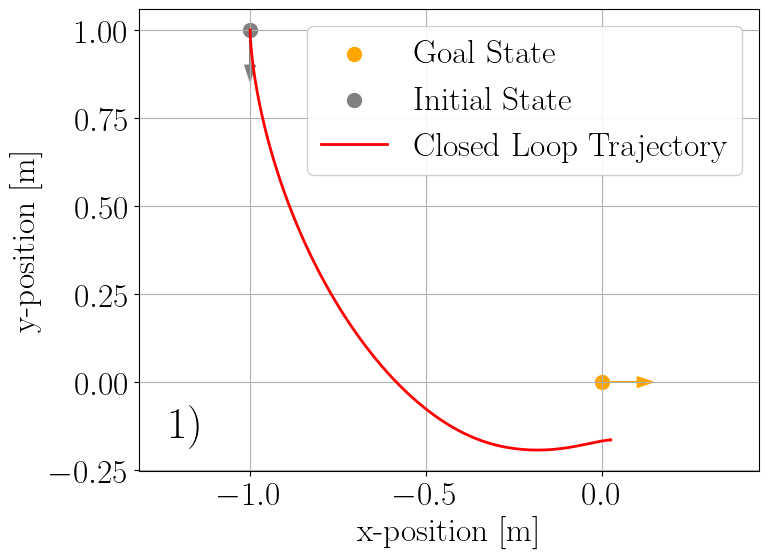

In [5]:
### 1) Myopic Exact model MPC ###
mpc_opts_1 = DifferentialDriveMPCOptions()
N = 250
mpc_opts_1.N = N
mpc_opts_1.step_sizes = [dt_inital_mpc]*N
mpc_opts_1.switch_stage = N+1
mpc_opts_1.integrator_type = "IRK"
mpc_1 = DifferentialDriveMPC(mpc_opts_1)

x_traj_1, u_traj_1, stage_costs, solve_times, SQP_iters = simulate_closed_loop(X0, mpc_1, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(y_ref_plotting, mpc=mpc_1, closed_loop_traj=x_traj_1, latexify=latexify, number=1, legend=True, save=save, initial_state=initial_state_plotting)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_1
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

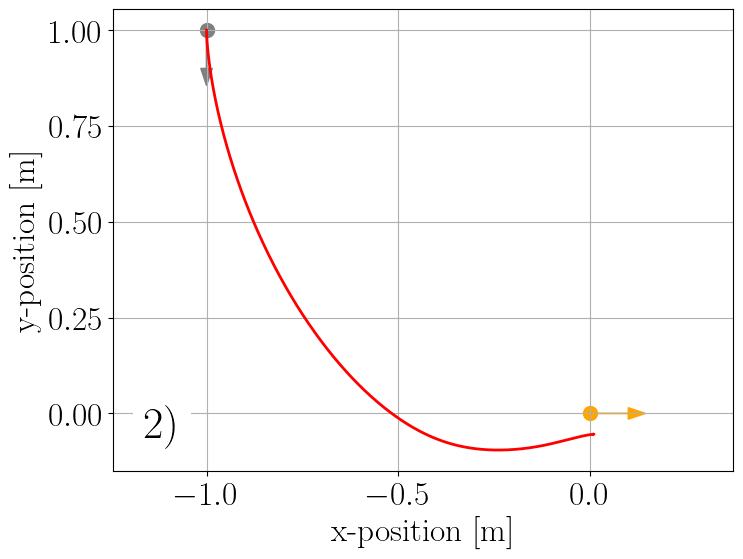

In [6]:
### 2) Larger step size ###
mpc_opts_2 = DifferentialDriveMPCOptions()
N = 250
mpc_opts_2.N = N
mpc_opts_2.step_sizes = [4*dt_inital_mpc]*N
mpc_opts_2.switch_stage = N+1
mpc_opts_2.integrator_type = "IRK"
mpc_2 = DifferentialDriveMPC(mpc_opts_2)

x_traj_2, u_traj_2, stage_costs, solve_times, SQP_iters = simulate_closed_loop(X0, mpc_2, duration, sim_solver=sim_solver, control_step=4*control_step)
plot_diff_drive_trajectory(y_ref_plotting, mpc=mpc_2, closed_loop_traj=x_traj_2, latexify=latexify, number=2, legend=False, save=save, initial_state=initial_state_plotting)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_2
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

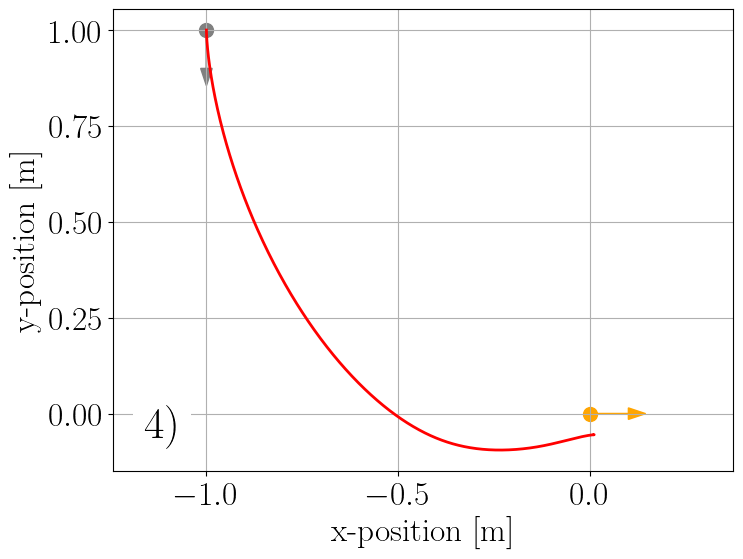

4705.67422404628


In [7]:
### 4) Exponential increase in stepsize ###
mpc_opts_4 = DifferentialDriveMPCOptions()
N = 80
mpc_opts_4.N = N
mpc_opts_4.step_sizes = compute_exponential_step_sizes(
    dt_initial=dt_inital_mpc,
    T_total=10,
    N_steps=N,
    plot=False
)
mpc_opts_4.switch_stage = N+1
mpc_opts_4.integrator_type = "IRK"
mpc_4 = DifferentialDriveMPC(mpc_opts_4)

x_traj_4, u_traj_4, stage_costs, solve_times, SQP_iters = simulate_closed_loop(X0, mpc_4, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(y_ref_plotting, mpc=mpc_4, closed_loop_traj=x_traj_4, latexify=latexify, number=4, legend=False, save=save, initial_state=initial_state_plotting)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_4
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

print(np.mean(stage_costs))

The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option full_step_dual is deprecated and has new name: globalization_full_step_dual
The option line_search_use_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option nlp_solver_step_length is deprecated and has new name: globalization_fixed_step_length
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globaliza

acados_solver_multiphase_ocp_33_1_967_20250605_111909_459176.c: In function ‘multiphase_ocp_33_1_967_20250605_111909_459176_acados_create_with_discretization’:
acados_solver_multiphase_ocp_33_1_967_20250605_111909_459176.c:6294:25: warning: too many arguments for format [-Wformat-extra-args]
 6294 |         fprintf(stderr, "multiphase_ocp_33_1_967_20250605_111909_459176_acados_create_with_discretization: new_time_steps should be NULL " \
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o actuators_diff_drive_with_actuators_model/actuators_diff_drive_with_actuators_impl_dae_fun.o actuators_diff_drive_with_actuators_model/actuators_diff_drive_with_actuators_impl_dae_fun.c
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o actuators_diff_drive_with_actuators_model/actuators_diff_drive

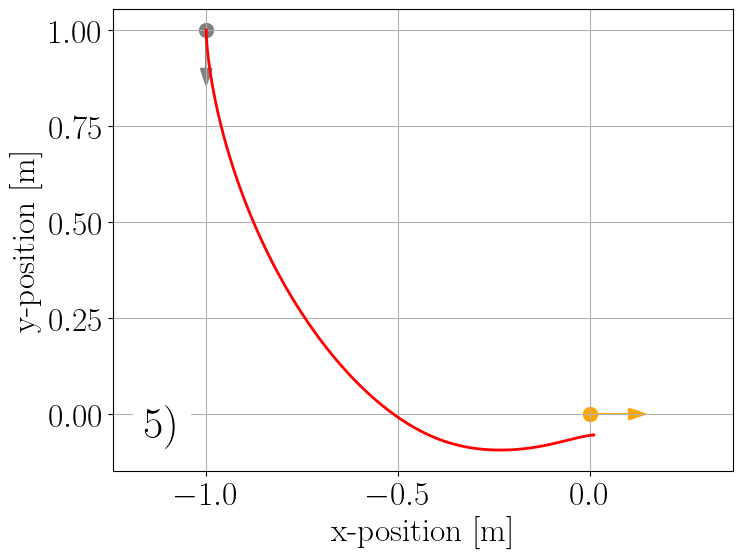

In [8]:
### 5) Model switching ###
mpc_opts_5 = DifferentialDriveMPCOptions()
N = 1000
mpc_opts_5.N = N
mpc_opts_5.step_sizes = [dt_inital_mpc]*N
mpc_opts_5.switch_stage = 33
mpc_opts_5.integrator_type = "IRK"
mpc_5 = DifferentialDriveMPC(mpc_opts_5)

x_traj_5, u_traj_5, stage_costs, solve_times, SQP_iters = simulate_closed_loop(X0, mpc_5, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(y_ref_plotting, mpc=mpc_5, closed_loop_traj=x_traj_5, latexify=latexify, number=5, legend=False, save=save, initial_state=initial_state_plotting)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_5
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

0.3324297556287886
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option full_step_dual is deprecated and has new name: globalization_full_step_dual
The option line_search_use_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option nlp_solver_step_length is deprecated and has new name: globalization_fixed_step_length
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has 

acados_solver_multiphase_ocp_20_1_60_20250605_112208_222603.c: In function ‘multiphase_ocp_20_1_60_20250605_112208_222603_acados_create_with_discretization’:
acados_solver_multiphase_ocp_20_1_60_20250605_112208_222603.c:1694:25: warning: too many arguments for format [-Wformat-extra-args]
 1694 |         fprintf(stderr, "multiphase_ocp_20_1_60_20250605_112208_222603_acados_create_with_discretization: new_time_steps should be NULL " \
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o actuators_diff_drive_with_actuators_model/actuators_diff_drive_with_actuators_impl_dae_fun.o actuators_diff_drive_with_actuators_model/actuators_diff_drive_with_actuators_impl_dae_fun.c
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o actuators_diff_drive_with_actuators_model/actuators_diff_drive

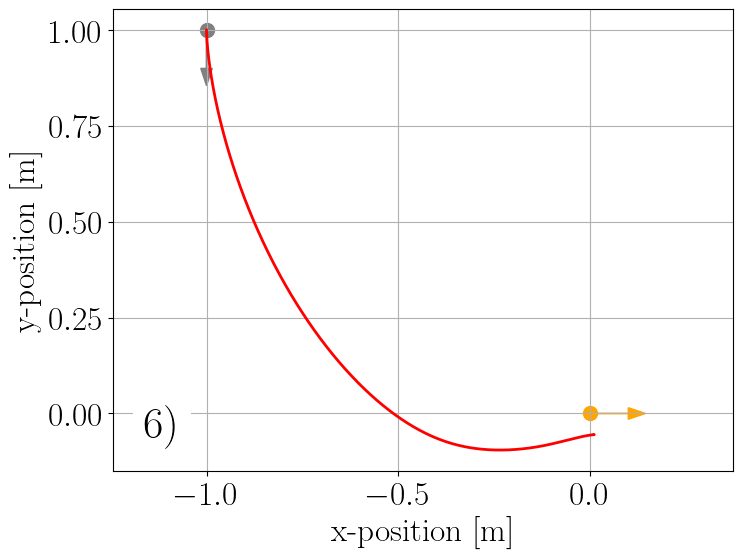

4705.7535912679905


In [9]:
### 6) Ours Mixed model, exponential step size increase ###
mpc_opts_6 = DifferentialDriveMPCOptions()
N = 80
mpc_opts_6.N = N
mpc_opts_6.step_sizes = compute_exponential_step_sizes(
    dt_initial=dt_inital_mpc,
    T_total=10,
    N_steps=N,
    plot=False
)
print(sum(mpc_opts_6.step_sizes[0:20]))
mpc_opts_6.switch_stage = 20 # only keep actuator model in first part of the horizon
mpc_opts_6.integrator_type = "IRK" # switch to ERK happens automatically in the class
mpc_6 = DifferentialDriveMPC(mpc_opts_6)

x_traj_6, u_traj_6, stage_costs, solve_times, SQP_iters = simulate_closed_loop(X0, mpc_6, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(y_ref_plotting, mpc=mpc_6, closed_loop_traj=x_traj_6, latexify=latexify, number=6, legend=False, save=save, initial_state=initial_state_plotting)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))
solve_times_pre_iter = [t / i if i != 0 else 0 for t, i in zip(solve_times, SQP_iters)]
mean_solve_time_per_iter.append(np.mean(solve_times_pre_iter))

del mpc_6
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

print(np.mean(stage_costs))

Run the following cell to safe / load a results file.

In [10]:
# save results or load them
import os
import pickle
from utils_shared import get_dir

data_dir = get_dir("data")
results_file = data_dir / "differential_drive/diff_drive_results.pkl"

if os.path.exists(results_file):
    with open(results_file, 'rb') as f:
        data = pickle.load(f)
    mean_costs = data['mean_costs']
    mean_solve_times = data['mean_solve_times']
    mean_solve_time_per_iter = data['mean_solve_time_per_iter']
else:
    # (Here assume mean_costs, mean_solve_times, mean_solve_time_per_iter are just computed)
    data = {
        'mean_costs': mean_costs,
        'mean_solve_times': mean_solve_times,
        'mean_solve_time_per_iter': mean_solve_time_per_iter
    }
    os.makedirs(os.path.dirname(results_file), exist_ok=True)
    with open(results_file, 'wb') as f:
        pickle.dump(data, f)


Next, we create bar plots and a pareto frontier of the observed closed-loop costs, solve times and solve times per SQP iteration. 

In [11]:
# Plotting options for the following plots
latexify=True
save=True

In [12]:
print(mean_costs)
print(mean_solve_times)
print(mean_solve_time_per_iter)

[4705.44794536638, 4955.323000879887, 4736.788876035878, 4705.67422404628, 4705.397932449907, 4705.7535912679905]
[0.2304520626666667, 0.028113414666666666, 0.06656902133333334, 0.019855664, 0.12030676866666666, 0.013875499333333333]
[0.016078632726726657, 0.0035412543596576545, 0.00419524290152056, 0.0013042408210448956, 0.008102876639223943, 0.0007961343116526608]


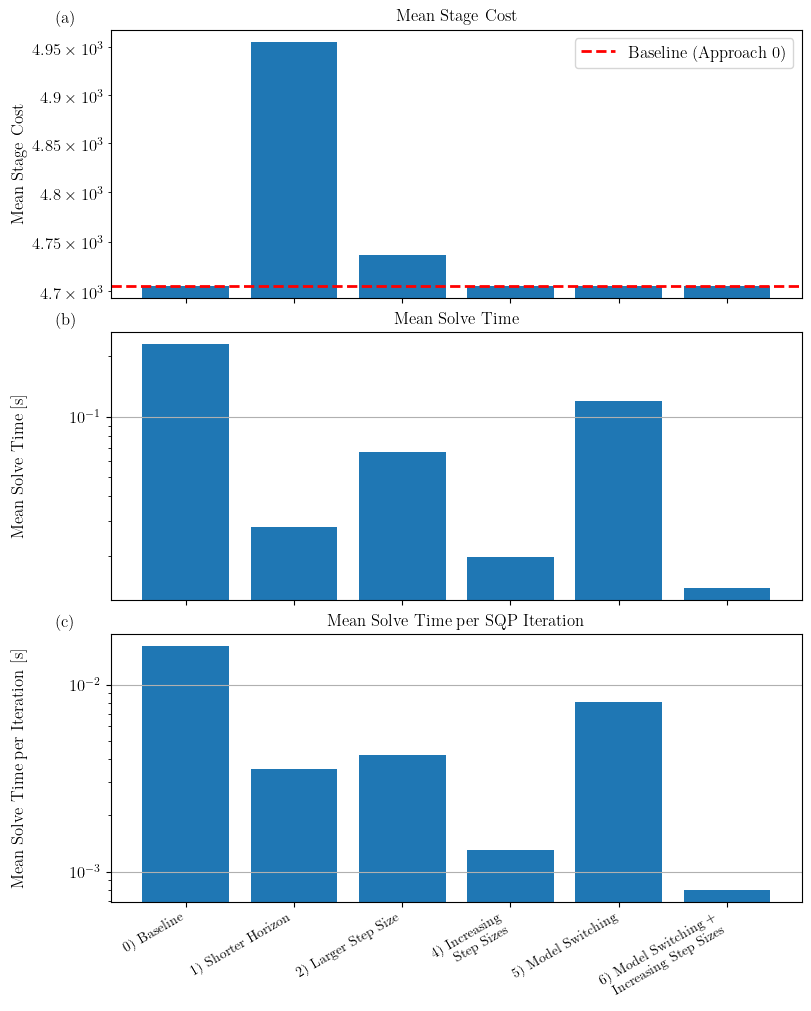

In [13]:
import matplotlib.pyplot as plt
from plotting_utils_shared import barplot

# Data: mean_costs, mean_solve_times, mean_solve_times_per_iter should be defined already
approach_labels = [
    '0) Baseline',
    '1) Shorter Horizon',
    '2) Larger Step Size',
    '4) Increasing\n    Step Sizes',
    '5) Model Switching',
    '6) Model Switching +\n    Increasing Step Sizes'
]


barplot(
    approach_labels,
    mean_costs,
    mean_solve_times,
    mean_solve_time_per_iter,
    subpath="differential_drive/diff_drive_barplot.pgf",
    latexify=latexify,
    save=save,
    figsize=(8, 10),
    fontsize=12,
)

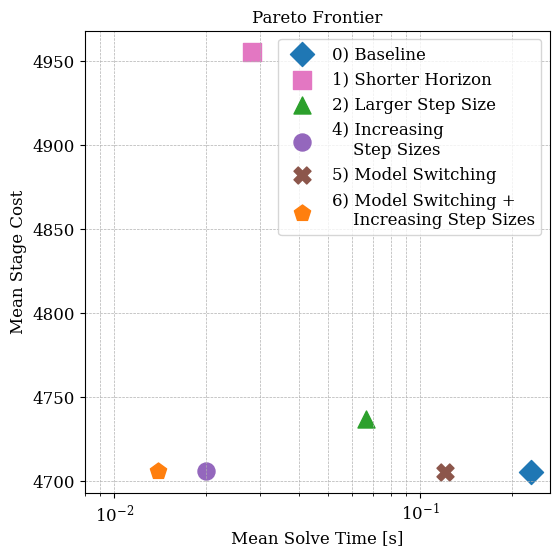

In [14]:
import matplotlib.pyplot as plt
from plotting_utils_shared import pareto_frontier

# distinct symbols per approach
markers = ['D', 's', '^', 'v', 'o', 'X', 'p']

# NEW: marker sizes per approach (indexed same as markers)
marker_sizes = [150, 150, 150, 150, 150, 150, 150]  # customize these

pareto_frontier(
    mean_solve_times,
    mean_costs,
    approach_labels,
    markers,
    marker_sizes,
    subpath="differential_drive/pareto_front_diff_drive.pdf",
    latexify=latexify,
    save=save,
    figsize=(6, 6),
    fontsize=12,
    x_lim=0.008,
    y_nonlog=True
)
